## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt

import discrepancy, visualization
from algorithms import ABC_algorithms, SNLABC, SNL2ABC, SMCABC, SMC2ABC, TPABC, TP2ABC
from problems import problem_IS

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition


 sampling from true posterior ... 

x_obs= [[-1. -1. -1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1. -1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.]
 [-1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1.  1.  1.]]


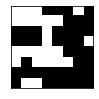

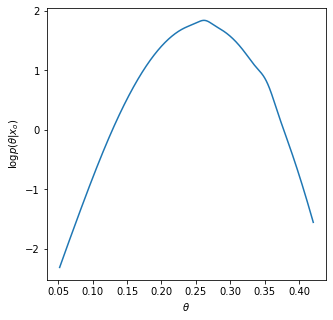

In [2]:
RERUN = False                                                  
DIR = 'results/IS'

## Define the problem
problem = problem_IS.IS_Problem(N=2000, n=1)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed data x_o
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
else:
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Get True posterior (rejection sampling approx)
print('\n sampling from true posterior ... \n')
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.num_sim = 20000
hyperparams.num_samples = 100
hyperparams.L = 1
tp_abc = TPABC.TP_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
if RERUN:
    tp_abc.run()
    true_samples = tp_abc.rej_samples
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    tp_abc = utils_os.load_algorithm(DIR, tp_abc)
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    
## Visualize the problem
problem.visualize()  
visualization.plot_likelihood(samples=true_samples, log_likelihood_function=tp_abc.log_likelihood)

## Inference

In [ ]:
## Sequential Monte Carlo ABC
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.num_sim = 10000
hyperparams.num_samples = 200
hyperparams.L = int(hyperparams.num_sim/1000)

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(len(smc_abc.posterior_array)):
    print('l=', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC', JSD_smc_array)

In [ ]:
## Sequential Monte Carlo ABC +
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:2'
hyperparams.num_sim = 10000
hyperparams.num_samples = 200
hyperparams.hidden_ratio = 0.02
hyperparams.L = int(hyperparams.num_sim/2000)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=100)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

In [ ]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:2'
hyperparams.num_sim = 10000
hyperparams.L = int(hyperparams.num_sim/1000)

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL', JSD_array)

In [ ]:
### Sequential Neural Likelihood +
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:3'
hyperparams.num_sim = 10000
hyperparams.L = int(hyperparams.num_sim/1000)
hyperparams.hidden_ratio = 0.02

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.l = l
    snl2_abc.vae_net = snl2_abc.vae_array[l]
    snl2_abc.nde_net = snl2_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL2', JSD_array)